In [38]:
from IPython.display import display, Math, Latex

$$\Huge{Κώδικας\ κι\ Αναλυση Μεθόδων}\\ Αρχικά\ κάνουμε\ εισαγωγή\ των\ βιβλιοθηκών\ που\ θα\ χρησιμοποιήσουμε.$$

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
import pandas as pd

$$Στη\ συνέχεια\ εισάγουμε\ το\ dataset\ που\ θα\ χρησιμοποιήσουμε\ ως\ ένα\ Pandas\ DataFrame\ και\ το\ ελέγχουμε\ συνοπτικά.$$

In [3]:
data = pd.read_csv(r'C:\Users\user\Desktop\datasets\dokimastika\data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

$$Θα\ κρατήσουμε\ ως\ labels\ των\ κατηγοριών\ μας\ το\ χαρακτηριστικό\ 'diagnosis'\ και\ τα\ features\ 2-31\ θα\ χρησιμοποιηθούν\\ ως\ δεδομένα\ ανάλυσης.\\ Αρχικά\ για\ να\ έχουμε\ μια\ πρώτη\ εικόνα\ του\ δείγματός\ μας,\ θα\ φτιάξουμε\ ένα\ pie\ chart\ που\ θα\ μας\ δείχνει\ την\ κατανομή\ των\ κατηγοριών.$$

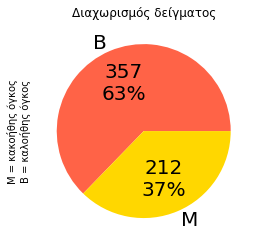

In [4]:
def label_function(val):
    return f'{val / 100 * len(data):.0f}\n{val:.0f}%'

data.groupby('diagnosis').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.title('Διαχωρισμός δείγματος')
plt.ylabel('Μ = κακοήθης όγκος\nΒ = καλοήθης όγκος')
plt.show()

$$Παρατηρούμε\ λοιπόν\ ότι\ στο\ δείγμα\ μας\ έχουμε\ 37\% \ κακοήθεις\ όγκους\ (M\ =\ Maligant)\ και\ 63\%\ καλοήθεις\ (B\ =\ Benign).\\ Έπειτα\ διαχωρίζουμε\ τα\ δεδομένα\ που\ θα\ χρησιμοποιήσουμε\ X\ (τροποποιώντας\ τα\ σε\ numpy\ arrays)\ σε\ σχέση\ με\ τους\ κατηγοριοποιητές\ Y\\ και\ μετασχηματίζουμε\ τα\ labels\ των\ κατηγοριών\ τοποθετώντας\ 1\ στα\ labels\ των\ κακοήθων\ όγκων\ και\ 0\ στα\ labels\ των\ καλοήθων\ όγκων.$$

In [5]:
new_data = data.to_numpy()
X = new_data[:, 3:31]
Y = new_data[:,1]
for i in range(len(Y)):
    if Y[i] == 'M':
        Y[i]=1
    else:
        Y[i] = 0

Y = list(Y)

$$Στη\ μελέτη\ μας\ η\ οποία\ αποσκοπεί\ στη\ σύγκριση\ των\ διαφόρων\ μεθόδων\ επιλογής\ χαρακτηριστικών,\ θα\ χρησιμοποιήσουμε\ ως\ classifiers\ δέντρα\ αποφάσεων\ και\ Naive\ Bayes.\ Όσον\ αφορά\ τα\ δέντρα\ αποφάσεων,\ για\ να\ υπάρχει\ ποικιλία,\ θα\ χρησιμοποιηθεί\ ο\ CART\ αλγόριθμος\ για\\ την\ επαγωγή\ τους,\ ενώ\ ως\ μέτρα\ επιλογής\ χαρακτηριστιών\ θα\ χρησιμοποιήσουμε\ τον\ δείκτη\ Gini\ και\ την\ Εντροπία.\\ Αρχικά\ θα\ χρησιμοποιήσουμε\ τις\ μεθόδους\ φίλτρου\ που\ περιγράφηκαν\ παραπάνω,\ παίρνοντας\ κάθε\ φορά\ τα\ k\ καλύτερα\ χαρακτηριστικά\\ που\ προέκυψαν\ με\ τη\ βοήθεια\ των\ στατιστικών\ μέτρων\ που\ χρησιμοποιήθηκαν.\\ Κάτι\ που\ θα\ πρέπει\ να\ ορίσουμε\ αρχικά\ ως\ μέτρο\ και\ αποτελεί\ κατά\ κάποιο\ τρόπο\ υπερπαράμετρο\ στο\ γενικότερο\ πρόβλημά\ μας,\ είναι\ το\\ ποσοστό\ train/test\ set\ που\ θα\ χωρίσουμε\ το\ δείγμα\ μας.\\ Μια\ πρώτη\ σκέψη\ είναι\ να\ το\ διαχωρίσουμε\ σε\ 70/30 \%.\ Αφού\ η\ υπολογιστική\ ισχύς\ μας\ το\ επιτρέπει,\ θα\ τρέξουμε\ όλες\ τις\ μεθόδους\ που\ θα\ χρησιμοποιήσουμε\ σε\ όλους\ τους\ αλγορίθμους,\ παίρνοντας\ όλους\ τους\ διακριτά\ καλούς\ συνδιασμούς.\\ Παρακάτω\ είναι\ ο\ κώδικας\ που\ θα\ χρησιμοποιηθεί\ για\ να\ μας\ δώσει\ μια\ εικόνα\ του\ παραπάνω\ ζητήματος.$$

In [6]:
def return_plot(test_size_perc):
  t = [i for i in range(1, 28)]
  Gini_chi2 = []
  Entropy_chi2 = []
  NB_chi2 = []
  Gini_mi = []
  Entropy_mi = []
  NB_mi = []
  Gini_f = []
  Entropy_f = []
  NB_f = []



  for i in range(1, 28):
      X_new = SelectKBest(chi2, k = i).fit_transform(X, Y)
      X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=test_size_perc * .1, random_state=0)

      dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
      dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
      NB = GaussianNB()

      dtGini.fit(X_train, Y_train)
      dtEntropy.fit(X_train, Y_train)
      NB.fit(X_train, Y_train)
      
      Gini_score = dtGini.score(X_test, Y_test)
      Entropy_score = dtEntropy.score(X_test, Y_test)
      NB_score = NB.score(X_test, Y_test)

      Gini_chi2.append(Gini_score)
      Entropy_chi2.append(Entropy_score)
      NB_chi2.append(NB_score)
      #----------------------------------------------------------------------------
      X_new = SelectKBest(mutual_info_classif, k = i).fit_transform(X, Y)
      X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=test_size_perc * .1, random_state=0)

      dtGini_new = DecisionTreeClassifier(criterion='gini', random_state=0)
      dtEntropy_new = DecisionTreeClassifier(criterion='entropy', random_state=0)
      NB_new = GaussianNB()

      dtGini_new.fit(X_train, Y_train)
      dtEntropy_new.fit(X_train, Y_train)
      NB_new.fit(X_train, Y_train)
      
      Gini_score_new = dtGini_new.score(X_test, Y_test)
      Entropy_score_new = dtEntropy_new.score(X_test, Y_test)
      NB_score_new = NB_new.score(X_train, Y_train)

      Gini_mi.append(Gini_score_new)
      Entropy_mi.append(Entropy_score_new)
      NB_mi.append(NB_score_new)
      #----------------------------------------------------------------------------
      X_new = SelectKBest(f_classif, k = i).fit_transform(X, Y)
      X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=test_size_perc * .1, random_state=0)

      dtGini_f = DecisionTreeClassifier(criterion='gini', random_state=0)
      dtEntropy_f = DecisionTreeClassifier(criterion='entropy', random_state=0)
      NB_f_model = GaussianNB()

      dtGini_f.fit(X_train, Y_train)
      dtEntropy_f.fit(X_train, Y_train)
      NB_f_model.fit(X_train, Y_train)
      
      Gini_score_f = dtGini_f.score(X_test, Y_test)
      Entropy_score_f = dtEntropy_f.score(X_test, Y_test)
      NB_score_f = NB_f_model.score(X_train, Y_train)

      Gini_f.append(Gini_score_f)
      Entropy_f.append(Entropy_score_f)
      NB_f.append(NB_score_f)

  return t, Gini_chi2, Entropy_chi2, NB_chi2, Gini_mi, Entropy_mi, NB_mi, Gini_f, Entropy_f, NB_f

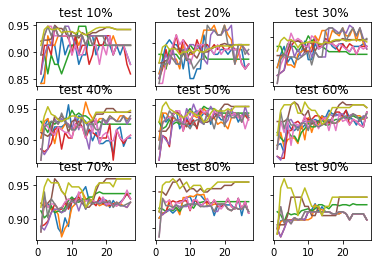

In [7]:
t_per = []

fig, axs = plt.subplots(3, 3)
perce = 1

for i in range(3):
  for j in range(3):
    empty_list = []
    t, Gini_chi2, Entropy_chi2, NB_chi2, Gini_mi, Entropy_mi, NB_mi, Gini_f, Entropy_f, NB_f = return_plot(perce)
    axs[i, j].plot(t, Gini_chi2)
    axs[i, j].plot(t, Entropy_chi2)
    axs[i, j].plot(t, NB_chi2)
    axs[i, j].plot(t, Gini_mi)
    axs[i, j].plot(t, Entropy_mi)
    axs[i, j].plot(t, NB_mi)
    axs[i, j].plot(t, Gini_f)
    axs[i, j].plot(t, Entropy_f)
    axs[i, j].plot(t, NB_f)
    axs[i, j].set_title('test ' + str(perce) +'0%')
    for h in range(len(Gini_chi2)):
        empty_list.append((Gini_chi2[h] + Entropy_chi2[h] + NB_chi2[h] + Gini_mi[h] + Entropy_mi[h] + NB_mi[h] + Gini_f[h] + Entropy_f[h] + NB_f[h])/9)
    t_per.append(empty_list)
    perce+=1
    
for ax in axs.flat:
    ax.label_outer()
    
#Αν θέλουμε να δούμε συγκεκριμένα σε ποια μέθοδο/αλγόριθμο αντιστοιχεί κάθε χρώμμα ενεργοποιούμε την παρακάτω εντολή
#plt.legend(['Gini_chi2', 'Entropy_chi2', 'NB_chi2', 'Gini_mi', 'Entropy_mi', 'NB_mi', 'Gini_f', 'Entropy_f', 'NB_f'])
#και μας βγάζει τις αντίστοιχες ονοματοδοσίες
#εδώ όμως δεν θα το κάνουμε αυτό γιατί στο notebook μας χαλάει την εικόνα
#ενδύκνειτε παρόλαυτά για κάποιους άλλους editors

plt.show()

$$Τώρα\ στο\ παρακάτω\ κομμάτι\ κώδικα\ παίρνουμε\ το\ μέσο\ όρο\ της\ ακρίβειας\ των\ μεθόδων\ για\ κάθε\ αριθμό\ πλήθους\ επιλογής\ χαρακτηριστικών\ και\ κάθε\ περίπτωση\ διαχωρισμού\ train/test\ set\ σε\ ποσοστά\ επί\ της\ εκατό\ όπως\ παραπάνω.$$

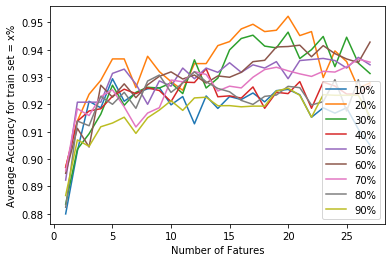

In [8]:
for i in t_per:
    plt.plot(t, i)
plt.xlabel('Number of Fatures')
plt.ylabel('Average Accuracy for train set = x%')
plt.legend(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.show()

$$Παρατηρούμε\ ότι\ σχεδόν\ για\ κάθε\ περίπτωση\ τελικής\ επιλογής\ πλήθους\ χαρακτηριστικών,\ έχουμε\ μεγαλύτερο\ accuracy\ όταν\ παίρνουμε\\ το\ test\ set\ να\ αποτελεί\ το\ 20\ ή\ 30\%\ του\ δείγματος.\ Ως\ εκ\ τούτου\ από\ εδώ\ και\ στο\ εξής\ θα\ επιλέξουμε\ να\ κάνουμε\ τον\ διαχωρισμό\ 75/25.\\ \\ Αυτό\ που\ ίσως\ θα\ μπορούσε\ να\ μας\ προκαλέσει\ κάποια\ εντύπωση\, είναι\ το\ γεγονός\ ότι\ σε\ κάθε\ περίπτωση\ το\ accuracy\ κάθε\ αλγορίθμου\ δεν\\ πέφτει\ κάτω\ απ'\ το\ 80\%,\ ανεξάρτητα\ απ'\ το\ διαχωρισμό\ των\ train/test\ sets.\ Ακόμα\ δηλαδή\ κι\ αν\ πάρουμε\ ως\ train\ set\ το\ 10\%\ του\ δείγματος,\ επιλέγοντας\ μέσω\ κάποιας\ μεθόδου\ επιλογής\ χαρακτηριστικών\ 1\ ή\ 2\ το\ πλήθος\ χαρακτηριστικά,\ το\ ποσοστό\ προβλεπτικής\ ακριβείας\ του\\ αλγορίθμου\ παραμένει\ αρκετά\ υψηλό.\ Αυτό\ μας\ λέει\ με\ μια\ πρώτη\ ματιά\ ότι\ οι\ αλγόριθμοι\ που\ χρησιμοποιούμε\ είναι\ αρκετά\ αποδοτικοί.\\ Από\ την\ άλλη\ μεριά,\ ενδεχομένως\ να\ παίζει\ ρόλο\ το\ γεγονός\ ότι\ κάνουμε\ εν\ τέλει\ δυαδική\ κατηγοριοποίηση.\ Αν\ δηλαδή\ είχαμε\\ περισσότερες\ κλάσεις,\ ενδεχομένως\ το\ ποσοστό\ ακριβείας\ μας\ να\ έπεφτε\ αρκετα.\ Αυτό\ μπορεί\ να\ ελεγχεί\ μελλοντικά\ εξετάζοντας\\ κάποιο\ άλλο\ dataset.\\ \\ Τώρα\ θα\ τρέξουμε\ ξανά\ όλους\ τους\ αλγορίθμους\ κι\ με\ ένα\ heat\ map\ θα\ βρούμε\ με\ ποιον\ συνδιασμό\ πετυχαίνουμε\ το\ μέγιστο\ ποσοστό\\ ακριβείας\ μοντέλου.$$

In [9]:
methods = ['Gini_chi2', 'Entropy_chi2', 'NB_chi2', 'Gini_mi', 'Entropy_mi', 'NB_mi', 'Gini_f', 'Entropy_f', 'NB_f']
num_of_features = [str(i) for i in range(1, 29)]

heat_map = np.zeros((9, 28))

for i in range(1, 29):
    X_new = SelectKBest(chi2, k = i).fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.25, random_state=0)

    dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB = GaussianNB()

    dtGini.fit(X_train, Y_train)
    dtEntropy.fit(X_train, Y_train)
    NB.fit(X_train, Y_train)
      
    Gini_score = dtGini.score(X_test, Y_test)
    Entropy_score = dtEntropy.score(X_test, Y_test)
    NB_score = NB.score(X_test, Y_test)

    heat_map[0][i-1] = Gini_score
    heat_map[1][i-1] = Entropy_score
    heat_map[2][i-1] = NB_score
    #----------------------------------------------------------------------------
    X_new = SelectKBest(mutual_info_classif, k = i).fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.25, random_state=0)

    dtGini_new = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy_new = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB_new = GaussianNB()

    dtGini_new.fit(X_train, Y_train)
    dtEntropy_new.fit(X_train, Y_train)
    NB_new.fit(X_train, Y_train)
      
    Gini_score_new = dtGini_new.score(X_test, Y_test)
    Entropy_score_new = dtEntropy_new.score(X_test, Y_test)
    NB_score_new = NB_new.score(X_train, Y_train)

    heat_map[3][i-1] = Gini_score_new
    heat_map[4][i-1] = Entropy_score_new
    heat_map[5][i-1] = NB_score_new
    #----------------------------------------------------------------------------
    X_new = SelectKBest(f_classif, k = i).fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.25, random_state=0)

    dtGini_f = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy_f = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB_f_model = GaussianNB()

    dtGini_f.fit(X_train, Y_train)
    dtEntropy_f.fit(X_train, Y_train)
    NB_f_model.fit(X_train, Y_train)
      
    Gini_score_f = dtGini_f.score(X_test, Y_test)
    Entropy_score_f = dtEntropy_f.score(X_test, Y_test)
    NB_score_f = NB_f_model.score(X_train, Y_train)

    heat_map[6][i-1] = Gini_score_f
    heat_map[7][i-1] = Entropy_score_f
    heat_map[8][i-1] = NB_score_f

In [10]:
for i in range(len(heat_map)):
    for j in range(len(heat_map[i])):
        heat_map[i][j] = round(heat_map[i][j], 2)

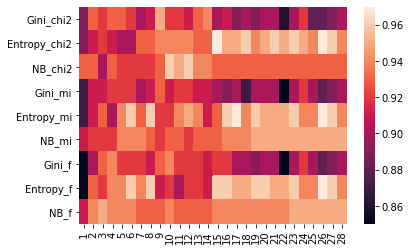

In [11]:
import seaborn as sns
ax = sns.heatmap(heat_map, xticklabels=num_of_features, yticklabels=methods)

$$Τέλος\ δίνουμε\ παρακάτω\ μια\ συνεχή\ προσέγγιση\ της\ κατανομής\ του\ accuracy\ rate\ για\ κάθε\ περίπτωση\ και\ στοιχεία\ της\ κατανομής\ τους,\\ όπως\ η\ διασπορά\ των\ τιμών\ και\ ο\ μέσος\ όρος.$$

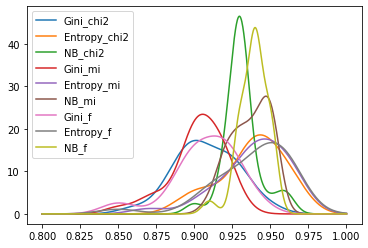

In [14]:
from scipy import stats

t=np.linspace(.8, 1, 1000)
for i in range(len(heat_map)):
    fet = heat_map[i]
    density = stats.kde.gaussian_kde(fet)
    plt.plot(t, density(t))

plt.legend(methods)
plt.show()

In [15]:
vars_methods = np.zeros((9))
means_methods = np.zeros((9))
for i in range(len(heat_map)):
    vars_methods[i] = np.var(heat_map[i])
    means_methods[i] = np.mean(heat_map[i])
    print(methods[i], ': Var =', np.var(heat_map[i]), ', Mean =', np.mean(heat_map[i]) )

Gini_chi2 : Var = 0.00039540816326530626 , Mean = 0.9078571428571429
Entropy_chi2 : Var = 0.00043112244897959085 , Mean = 0.937857142857143
NB_chi2 : Var = 0.00013099489795918317 , Mean = 0.9310714285714285
Gini_mi : Var = 0.00030969387755102094 , Mean = 0.902142857142857
Entropy_mi : Var = 0.0004994897959183664 , Mean = 0.9392857142857144
NB_mi : Var = 0.00015038265306122355 , Mean = 0.9367857142857142
Gini_f : Var = 0.00046326530612244936 , Mean = 0.9071428571428569
Entropy_f : Var = 0.0006289540816326518 , Mean = 0.9382142857142858
NB_f : Var = 8.099489795918309e-05 , Mean = 0.9389285714285714


$$Παρατηρούμε\ ότι\ ίσως\ ο\ καλύτερος\ συνδιασμός\ είναι\ decision\ tree\ χρησιμοποιώντας\ την\ εντροπία,\ όπου\ χρησιμοποιώντας\ χ2-test,\\ μπορούμε\ να\ πετύχουμε\ εξαιρετικό\ ποσοστό\ ακριβείας\ πρόβληεψης\ χρησιμοποιώντας\ 15\ χαρακτηριστικά.\\ Γενικότερα\ παρατηρούμε\ ότι\ decision\ trees\ χρησιμοποιώντας\ δείκτη\ Gini\ παρουσιάζουν\ καλύτερο\ ποσοστό\ ακριβείας\ πρόβλεψης\ όσο\\ μικρότερο\ είναι\ το\ πλήθος\ των\ χαρακτηριστικών\ που\ επιλέγουμε\ να\ χρησιμοποιήσουμε,\ αν\ και\ γενικότερα\ φαίνεται\ να\ είναι\ σε\ κάθε\\ περίπτωση\ χειρότερο\ σε\ σχέση\ με\ τους\ άλλους\ δύο\ αλγορίθμους.\\ Decision\ trees\ χρησιμοποιώντας\ εντροπία\ φαίνονται\ να\ λειτουργούν\ αρκετά\ καλύτερα\ χρησιμοποιώντας\ περισσότερα\ χαρακτηριστικά\\ ανεξαρτήτου\ της\ μεθόδου\ επιλογής\ που\ χρησιμοποιούμε,\ ενώ\ ο\ Naive\ Bayes\ φαίνεται\ να\ έχει\ σταθερή\ απόδοση\ σε\ γενικές\\ γραμμές\ (αυτό\ γίνεται\ πολύ\ γρήγορα\ κατανοητό\ βλέποντας\ ότι\ το\ accuracy\ του\ έχει\ σταθερά\ πολύ\ μικρή\ διασπορά).\\ Αντίστοιχα\ θα\ φτιάξουμε\ τις\ συνεχείς\ προσεγγίσεις\ των\ κατανομών\ για\ την\ ακρίβεια\ που\ αντιστοιχούν\ σε\ καθεμιά\ απ'\ τις\ περιπτώσεις\\ επιλογής\ πλήθους\ χαρακτηριστικών.\ Είναι\ φανερό\ ότι\ επειδή\ τα\ decision\ trees\ με\ Gini\ χαλάνε\ πολύ\ απ'\ τα\ μισά\ features\ κι\ έπειτα\, για\ τα\\ αντίστοιχα\ πλήθη\ χαρακτηριστικών\ θα\ έχουμε\ μεγαλύτερη\ διασπορά.\ Βέβαια,\ ενδεχομένως\ αν\ χρησιμοποιούσαμε\ περισσότερους\ αλγορίθμους\ ή/και\ περισσότερες\ μεθόδους\ φίλτρου,\ αυτό\ να\ μην\ ήταν\ φανερό,\ αλλά\ αποτελεί\ υπόθεση\ που\ μπορεί\ να\ μας\ απασχολήσει\ σε\ κάποια\\ μελλοντική\ εργασία.$$

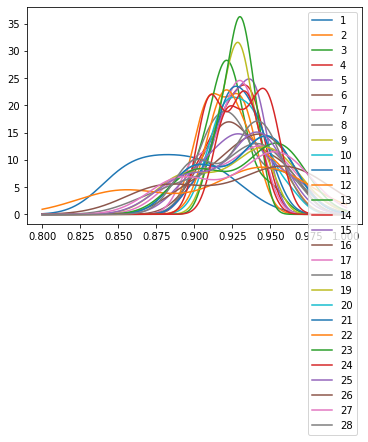

In [16]:
for i in range(28):
    fet = heat_map[:,i]
    density = stats.kde.gaussian_kde(fet)
    plt.plot(t, density(t))

plt.legend(num_of_features)
plt.show()

In [17]:
vars_features = np.zeros((28))
means_features = np.zeros((28))
for i in range(len(heat_map[0])):
    vars_features[i] = np.var(heat_map[:,i])
    means_features[i] = np.mean(heat_map[:,i])
    print(num_of_features[i], ': Var =', np.var(heat_map[:,i]), ', Mean =', np.mean(heat_map[:,i]) )

1 : Var = 0.0006913580246913593 , Mean = 0.8855555555555557
2 : Var = 0.00015555555555555535 , Mean = 0.9199999999999999
3 : Var = 0.00017283950617283915 , Mean = 0.9222222222222223
4 : Var = 0.00018024691358024616 , Mean = 0.9255555555555556
5 : Var = 0.0001728395061728386 , Mean = 0.9277777777777777
6 : Var = 0.0003654320987654309 , Mean = 0.931111111111111
7 : Var = 0.00019999999999999952 , Mean = 0.9233333333333333
8 : Var = 0.000343209876543209 , Mean = 0.9288888888888889
9 : Var = 0.00012098765432098707 , Mean = 0.9288888888888889
10 : Var = 0.00020987654320987555 , Mean = 0.931111111111111
11 : Var = 0.0001950617283950609 , Mean = 0.9277777777777777
12 : Var = 0.00024444444444444345 , Mean = 0.9299999999999999
13 : Var = 8.395061728395017e-05 , Mean = 0.9277777777777777
14 : Var = 0.000155555555555555 , Mean = 0.9233333333333333
15 : Var = 0.0004987654320987644 , Mean = 0.9311111111111112
16 : Var = 0.0004888888888888877 , Mean = 0.9333333333333331
17 : Var = 0.00066666666666666

In [18]:
print('Var of Var of Methods =', np.var(vars_methods) ,'\nVar of Var of Features =', np.var(vars_features))
print('Mean of Var of Methods =', np.mean(means_methods),'\nMean of Var of Features =', np.mean(means_features))

Var of Var of Methods = 3.1448564544865536e-08 
Var of Var of Features = 1.6675503671976327e-07
Mean of Var of Methods = 0.9265873015873015 
Mean of Var of Features = 0.9265873015873015


$$
Τώρα\ θα\ περάσουμε\ σε\ εφαρμογή\ ενσωματωμένων\ μεθόδων\ και\ πιο\ συγκεκριμένα\ στη\ LASSO\ και\ στη\ Ridge\ Regression.\\
Εδώ\ θα\ πρέπει\ να\ κάνουμε\ και\ tuning\ στις\ υπερπαραμέτρους\ της\ κάθε\ μεθόδου.\\
Αρχικά\ θα\ τρέξουμε\ τους\ αλγορίθμους\ μας\ για\ διάφορες\ τιμές\ της\ υπερπαραμέτρου\ \lambda\ για\ τη\ LASSO.\\ Σε\ όλες\ τις\ ακόλουθες\ περιπτώσεις\ χρησιμοποιείται\ διαχωρισμός\ 70/30.
$$

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\from_model.py:196: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.estimator_.fit(X, y, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.156245785521513, tolerance: 0.013301230228471017
  positive)


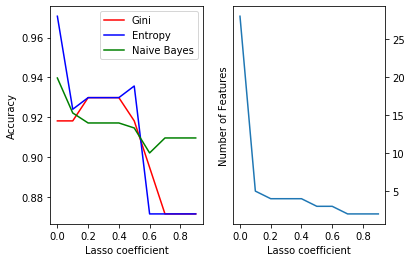

In [35]:
t = [i * .1 for i in range(10)]
Gini = []
Entropy = []
Naive_Bayes = []

features = []

for i in range(10):
    lasso_l1 = Lasso(alpha=i * .1)
    model = SelectFromModel(lasso_l1)
    X_new = model.fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)

    features.append(len(X_new[0]))
    
    dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB = GaussianNB()

    dtGini.fit(X_train, Y_train)
    dtEntropy.fit(X_train, Y_train)
    NB.fit(X_train, Y_train)
    
    Gini_score = dtGini.score(X_test, Y_test)
    Entropy_score = dtEntropy.score(X_test, Y_test)
    NB_score = NB.score(X_train, Y_train)

    Gini.append(Gini_score)
    Entropy.append(Entropy_score)
    Naive_Bayes.append(NB_score)


fig, axs = plt.subplots(1,2)

axs[0].plot(t, Gini, color='red')
axs[0].plot(t, Entropy, color='blue')
axs[0].plot(t, Naive_Bayes, color='green')
axs[0].legend(['Gini', 'Entropy', 'Naive Bayes'])
axs[0].set_xlabel('Lasso coefficient')
axs[0].set_ylabel('Accuracy')

axs[1].plot(t, features)
axs[1].yaxis.tick_right()
axs[1].set_xlabel('Lasso coefficient')
axs[1].set_ylabel('Number of Features')


plt.show()

$$
Παραπάνω\ τρέξαμε\ τους\ αλγορίθμους\ για\ \lambda \in [0,1]\ με\ βήμα\ διακριτοποίησης\ του\ διαστήματος\ αυτού\ 1/10.\ Αυτό\ που\ παρατηρούμε\ είναι\\ απότομη\ πτώση\ στο\ accuracy\ για\ το\ decision\ tree\ με\ εντροπία\ για \lambda \ μεταξύ\ 0.5\ και\ 0.6.\\ Παρακάτω\ παρουσιάζονται\ τα\ αντίστοιχα\ αποτελέσματα\ για\ \lambda\in [0,3]\ και\ βήμα\ διακριτοποίησης\ 1/1000.\ Εδώ\ παρατηρούμε\ ότι\ για\\ \lambda >1.9\ \ \ \ \ \ το\ accuracy\ και\ για\ τις \ 3\ μεθόδους \ φαίνεται \ να \ συγκλίνει \ σε \ κάποιες \ συγκεκριμένες\ τιμές.\ Κάνοντας \ μια\ πιο\ προσεκτική\ και\\ λεπτομερή\ μελέτη\ θα\ διαπιστώσουμε\ ότι\ για\ \lambda\in [0.52,0.54]\ παρατηρείται\ απότομη\ πτώση\ και\ έπειτα\ πάλι\ ξαφνική\\ άνοδος\ (από\ 3\ σε\ 2\ κι\ από\ 2\ ξανά\ σε\ 3)\ των\ επιλεχθέντων\ χαρακτηριστικών.\ Αυτό\ ενδεχομένως\ να\ οφείλεται\ σε\ υπολογιστικά\ σφάλματα,\\ όπως\ πχ\ σε\ σφάλματα\ στρογγύλευσης\ κτλ.\ Το\ ίδιο\ παρατηρείται\ και\ για\ άλλα\ μικρά\ διαστήματα\ του\ \lambda \ κοντά \ στο \ μηδέν.$$

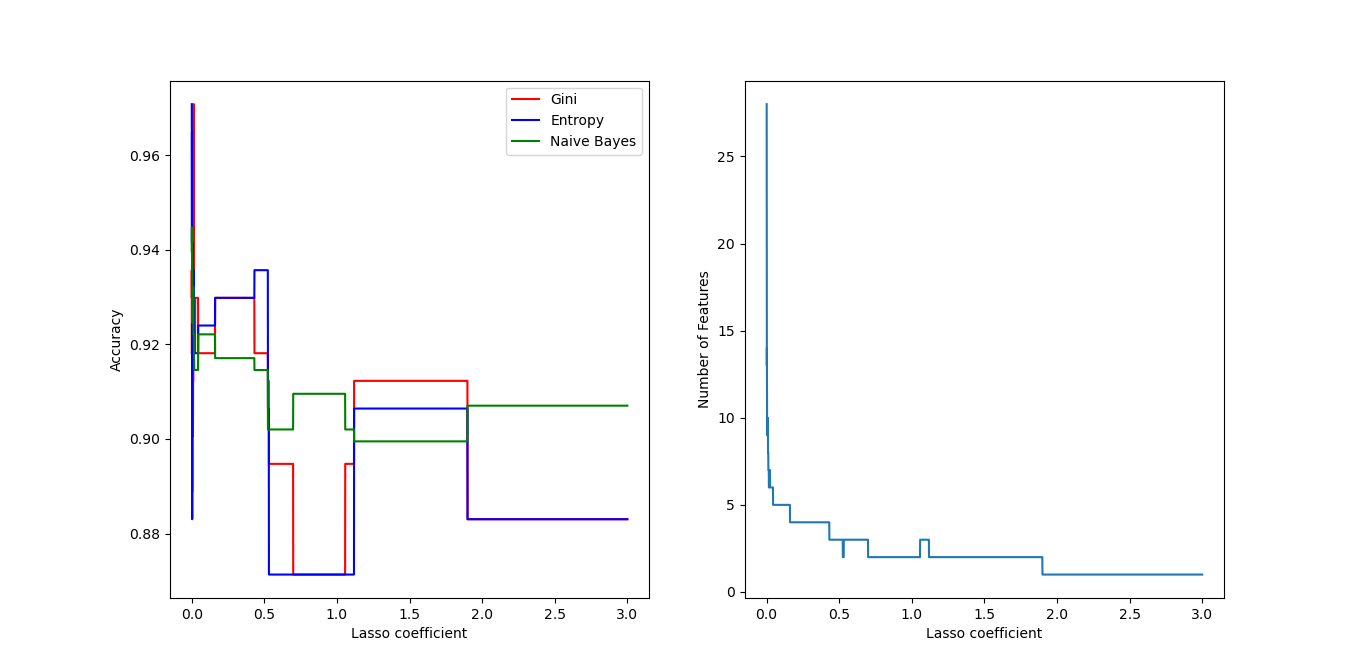

$$Απ'\ τα\ παραπάνω\ συμπεραίνουμε\ πως\ η\ βέλτιστη\ τιμή\ της\ υπερπαραμέτρου\ \lambda \ φαίνεται\ να\ είναι\ μεταξύ\ 0.1\ και\ 0.5\ όπου\ τα\ decision\ tress\\ έχουν\ accuracy\ πάνω\ από\ 0.9225\ και\ βλέπουμε\ ότι\ επιλέγονται\ 3-5\ χαρακτηριστικά.\\ Από\ την\ άλλη,\ ο\ Naive\ Bayes\ φαίνεται\ να\ έχει\ καλύτερη\ απόδοση\ για\ \lambda \ στο\ διάστημα\ [0.04, 0.16]\ με\ χρήση\ 5 \ χαρακτηριστικών\\ κι \ accuracy\ 0.9221.$$

$$Αντίστοιχα\ δουλεύουμε\ και\ για\ την\ μέθοδο\ με\ Ridge\ Regression.$$

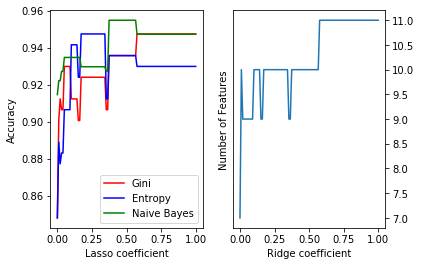

In [43]:
t = np.linspace(.0, 1, 100)
Gini = []
Entropy = []
Naive_Bayes = []

features = []

for i in range(len(t)):
    ridge_l1 = Ridge(alpha=t[i])
    model = SelectFromModel(ridge_l1)
    X_new = model.fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)

    features.append(len(X_new[0]))
    
    dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB = GaussianNB()

    dtGini.fit(X_train, Y_train)
    dtEntropy.fit(X_train, Y_train)
    NB.fit(X_train, Y_train)
    
    Gini_score = dtGini.score(X_test, Y_test)
    Entropy_score = dtEntropy.score(X_test, Y_test)
    NB_score = NB.score(X_train, Y_train)

    Gini.append(Gini_score)
    Entropy.append(Entropy_score)
    Naive_Bayes.append(NB_score)


fig, axs = plt.subplots(1,2)

axs[0].plot(t, Gini, color='red')
axs[0].plot(t, Entropy, color='blue')
axs[0].plot(t, Naive_Bayes, color='green')
axs[0].legend(['Gini', 'Entropy', 'Naive Bayes'])
axs[0].set_xlabel('Lasso coefficient')
axs[0].set_ylabel('Accuracy')

axs[1].plot(t, features)
axs[1].yaxis.tick_right()
axs[1].set_xlabel('Ridge coefficient')
axs[1].set_ylabel('Number of Features')


plt.show()

$$Εδώ\ η\ παράμετρος\ μας\ βρίσκεται\ στο\ [0,1]\ με\ βήμα\ διακριτοποίησης\ 1/100.\ Στο\ διάστημα\ [0,0.4]\ παρατηρούμε\ έντονες\ αλλάγές\ στο\ πλήθος\\ των\ επιλεχθέντων\ χαρακτηριστικών\ κι\ αυτό\ πιθανότατα\ πάλι\ να\ οφείλεται\ σε\ υπολογιστικά\ σφάλματα\ στρογγύλευσης.\ Για\ το\ λόγο\ αυτό\\ παρακάτω\ φαίνονται\ τα\ αποτελέσματα\ σε\ μελέτη\ του\ διαστήματος\ [0, 100]\ με\ βήμα\ διακριτοποίησης\ 1/1000.$$

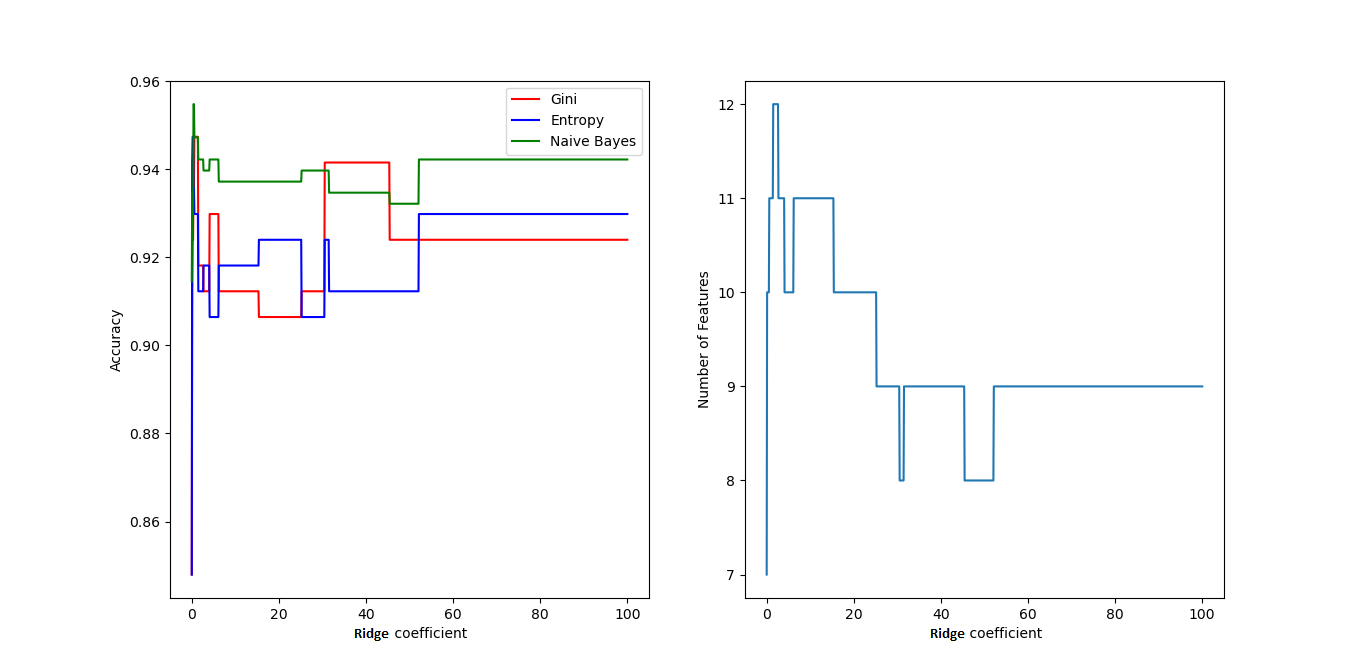

$$Σε\ αυτή\ την\ περίπτωση\ παρατηρούμε\ ότι\ είναι\ σχεδό\ σταθερά\ καλύτερος\ ο\ Naive\ Bayes\ για\ τις\ διάφορες\ τιμές\ της\ υπερπαραμέτρου\ \lambda .\\ Παρατηρούμε\ επίσης\ ότι\ ο\ διαχωρισμός\ με\ Ridge\ Regression\ φαίνεται\ να\ έχει\ συνολικά\ καλύτερες\ αποδόσεις\ όσον\ αφορά\ το\ accuracy\ για\\ τις\ διάφορες\ τιμές\ της\ υπερπαραμέτρου\ σε\ σχέση\ με\ την\ LASSO,\ παρότι\ φαίνεται\ να\ κρατά\ τελικά\ περισσότερα\ χαρακτηριστικά.\ Αυτό\\ ενδεχομένως\ να\ μην\ μας\ ενοχλεί\ βέβαια\ γιατί\ και\ πάλι\ είναι\ κατά\ μέσο\ όρο\ σχεδόν\ το\ 1/3\ των\ αρχικών.\ Τέλος\ είναι\ φανερό\ ότι\ από\\ κάποια\ τιμή\ κι\ έπειτα\ (σίγουρα\ για\ \lambda >60),\ το\ accuracy\ και\ των\ τριών\ αλγορίθμων\ φαίνεται\ να\ συγκλίνει\ σε\ κάποιες\  συγκεκριμένες\ τιμές.$$

$$Τώρα\ θα\ περάσουμε\ στις\ μεθόδους\ περιτυλίγματος\ με\ τη\ βοήθεια\ της\ βιβλιοθήκης\ mlxtend.$$

In [48]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [88]:
features_names = data.columns
features_names = tuple(features_names[3:31])

In [96]:
dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
NB = GaussianNB()

sfs1 = SFS(dtGini, k_features=28, forward=True, floating=False, verbose=2, scoring='accuracy', cv=0)

sfs1 = sfs1.fit(X, Y, custom_feature_names=features_names)

sfs2 = SFS(dtEntropy, k_features=28, forward=True, floating=False, verbose=2, scoring='accuracy', cv=0)

sfs2 = sfs2.fit(X, Y, custom_feature_names=features_names)

sfs3 = SFS(NB, k_features=28, forward=True, floating=False, verbose=2, scoring='accuracy', cv=0)

sfs3 = sfs3.fit(X, Y, custom_feature_names=features_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished

[2021-11-17 19:18:43] Features: 1/28 -- score: 0.9947275922671354[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.0s finished

[2021-11-17 19:18:43] Features: 2/28 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.1s finished

[2021-11-17 19:18:43] Features: 3/28 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.

In [97]:
sfs1.subsets_

{1: {'feature_idx': (6,),
  'cv_scores': array([0.99472759]),
  'avg_score': 0.9947275922671354,
  'feature_names': ('concave points_mean',)},
 2: {'feature_idx': (0, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean', 'concave points_mean')},
 3: {'feature_idx': (0, 1, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean', 'perimeter_mean', 'concave points_mean')},
 4: {'feature_idx': (0, 1, 2, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'concave points_mean')},
 5: {'feature_idx': (0, 1, 2, 3, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'smoothness_mean',
   'concave points_mean')},
 6: {'feature_idx': (0, 1, 2, 3, 4, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'smooth

In [98]:
sfs2.subsets_

{1: {'feature_idx': (6,),
  'cv_scores': array([0.99472759]),
  'avg_score': 0.9947275922671354,
  'feature_names': ('concave points_mean',)},
 2: {'feature_idx': (0, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean', 'concave points_mean')},
 3: {'feature_idx': (0, 1, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean', 'perimeter_mean', 'concave points_mean')},
 4: {'feature_idx': (0, 1, 2, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'concave points_mean')},
 5: {'feature_idx': (0, 1, 2, 3, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'smoothness_mean',
   'concave points_mean')},
 6: {'feature_idx': (0, 1, 2, 3, 4, 6),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'smooth

In [99]:
sfs3.subsets_

{1: {'feature_idx': (21,),
  'cv_scores': array([0.91915641]),
  'avg_score': 0.9191564147627417,
  'feature_names': ('perimeter_worst',)},
 2: {'feature_idx': (21, 23),
  'cv_scores': array([0.9543058]),
  'avg_score': 0.9543057996485061,
  'feature_names': ('perimeter_worst', 'smoothness_worst')},
 3: {'feature_idx': (20, 21, 23),
  'cv_scores': array([0.97012302]),
  'avg_score': 0.9701230228471002,
  'feature_names': ('texture_worst', 'perimeter_worst', 'smoothness_worst')},
 4: {'feature_idx': (10, 20, 21, 23),
  'cv_scores': array([0.97188049]),
  'avg_score': 0.9718804920913884,
  'feature_names': ('texture_se',
   'texture_worst',
   'perimeter_worst',
   'smoothness_worst')},
 5: {'feature_idx': (10, 13, 20, 21, 23),
  'cv_scores': array([0.97188049]),
  'avg_score': 0.9718804920913884,
  'feature_names': ('texture_se',
   'smoothness_se',
   'texture_worst',
   'perimeter_worst',
   'smoothness_worst')},
 6: {'feature_idx': (7, 10, 13, 20, 21, 23),
  'cv_scores': array([0.971

In [128]:
gini_sfs_score = []
entropy_sfs_score = []
nb_sfs_score = []

t = [i+1 for i in range(28)]

for i in sfs1.subsets_.values():
    gini_sfs_score.append(i['cv_scores'])
for i in sfs2.subsets_.values():
    entropy_sfs_score.append(i['cv_scores'])
for i in sfs3.subsets_.values():
    nb_sfs_score.append(i['cv_scores']) 

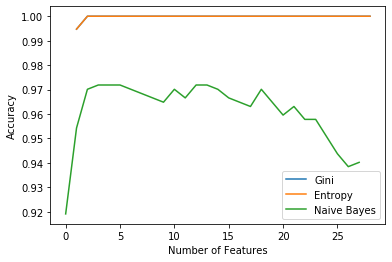

In [129]:
plt.plot(t, gini_sfs_score)
plt.plot(t, entropy_sfs_score)
plt.plot(nb_sfs_score)
plt.legend(['Gini', 'Entropy', 'Naive Bayes'])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.show()

$$Παρατηρούμε\ προς\ μεγάλη\ μας\ έκπληξη\ ότι\ με\ 1\ χαρακτηριστικό\ μπορούμε\ να\ πετύχουμε\ accuracy\ πάνω\ από\ 99\%\ για\ τα\ decision\ trees\ και\\ παραμένει\ στη\ μονάδα\ για\ κάθε\ επόμενο\ feature\ που\ προστίθεται,\ ενώ\ για\ τον\ Naive Bayes\ έχουμε\ μια\ μικρή\ διασπορά\ στο\ accuracy.\ Αυτό\\ προφανώς\ οφείλεται\ στο\ γεγονός\ ότι\  οι\ wrapper\ μέθοδοι\ στηρίζονται\ εξ\ ολοκλήρου\ στον\ αλγόριθμο\ που\ χρησιμοποιούμε.\ Φαίνεται\ λοιπόν\\ ότι\ η \ πρόσθια\ επιλογή \ ενδύκνειται\ για\ decision\ trees..$$

$$Τώρα\ θα\ τρέξουμε\ κι\ οπίσθια\ επιλογή.$$

In [119]:
dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
NB = GaussianNB()


sbs1 = SFS(dtGini, k_features=1, forward=False, floating=False, verbose=2, scoring='accuracy', cv=0)
sbs1 = sbs1.fit(X, Y, custom_feature_names=features_names)
    
sbs2 = SFS(dtEntropy, k_features=1, forward=False, floating=False, verbose=2, scoring='accuracy', cv=0)
sbs2 = sbs2.fit(X, Y, custom_feature_names=features_names)

sbs3 = SFS(NB, k_features=1, forward=False, floating=False, verbose=2, scoring='accuracy', cv=0)
sbs3 = sbs3.fit(X, Y, custom_feature_names=features_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.0s finished

[2021-11-17 19:59:57] Features: 27/1 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.2s finished

[2021-11-17 19:59:58] Features: 26/1 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.8s finished

[2021-11-17 19:59:59] Features: 25/1 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:  

In [122]:
sbs1.subsets_

{28: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'smoothness_mean',
   'compactness_mean',
   'concavity_mean',
   'concave points_mean',
   'symmetry_mean',
   'fractal_dimension_mean',
   'radius_se',
   'texture_se',
   'perimeter_se',
   'area_se',
   'smoothness_se',
   'compactness_se',
   'concavity_se',
   'concave points_se',
   'symmetry_se',
   'fractal_dimension_se',
   'radius_worst',
   'texture_worst',
   'perimeter_worst',
   'area_worst',
   'smoothness_worst',
   'compactness_worst',
   'concavity_worst',
   'concave points_worst',
   'symmetry_worst')},
 27: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18

In [123]:
sbs2.subsets_

{28: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'smoothness_mean',
   'compactness_mean',
   'concavity_mean',
   'concave points_mean',
   'symmetry_mean',
   'fractal_dimension_mean',
   'radius_se',
   'texture_se',
   'perimeter_se',
   'area_se',
   'smoothness_se',
   'compactness_se',
   'concavity_se',
   'concave points_se',
   'symmetry_se',
   'fractal_dimension_se',
   'radius_worst',
   'texture_worst',
   'perimeter_worst',
   'area_worst',
   'smoothness_worst',
   'compactness_worst',
   'concavity_worst',
   'concave points_worst',
   'symmetry_worst')},
 27: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18

In [124]:
sbs3.subsets_

{28: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27),
  'cv_scores': array([0.94024605]),
  'avg_score': 0.9402460456942003,
  'feature_names': ('texture_mean',
   'perimeter_mean',
   'area_mean',
   'smoothness_mean',
   'compactness_mean',
   'concavity_mean',
   'concave points_mean',
   'symmetry_mean',
   'fractal_dimension_mean',
   'radius_se',
   'texture_se',
   'perimeter_se',
   'area_se',
   'smoothness_se',
   'compactness_se',
   'concavity_se',
   'concave points_se',
   'symmetry_se',
   'fractal_dimension_se',
   'radius_worst',
   'texture_worst',
   'perimeter_worst',
   'area_worst',
   'smoothness_worst',
   'compactness_worst',
   'concavity_worst',
   'concave points_worst',
   'symmetry_worst')},
 27: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
  

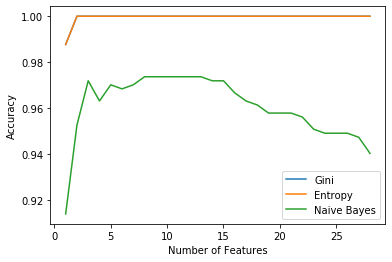

In [130]:
gini_sbs_score = []
entropy_sbs_score = []
nb_sbs_score = []

t = [28-i for i in range(28)]

for i in sbs1.subsets_.values():
    gini_sbs_score.append(i['cv_scores'])
for i in sbs2.subsets_.values():
    entropy_sbs_score.append(i['cv_scores'])
for i in sbs3.subsets_.values():
    nb_sbs_score.append(i['cv_scores'])

plt.plot(t, gini_sbs_score)
plt.plot(t, entropy_sbs_score)
plt.plot(t, nb_sbs_score)

plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend(['Gini', 'Entropy', 'Naive Bayes'])
plt.show()

$$Βλέπουμε\ ότι\ και\ για\ την\ οπίσθια\ επιλογή\ παρατηρούμε\ τα\ ίδια\ αποτελέσματα\ αναφορικά\ με\ τις\ επιδόσεις\ των\ αλγορίθμων.\ Κι\ εδώ\ πάλι\\ φαίνεται\ τα\ decision\ trees\ να\ λειτουργούν\ καλύτερα\ σε\ σχέση\ με\ τον\ Naive\ Bayes,\ o\ οποίος\ παρούσιάζει\ και\ μια\ μικρή\ διασπορά\\ όσον\ αφορά\ το\ accuracy.$$